In [75]:
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sksurv.datasets import load_gbsg2, load_breast_cancer, load_veterans_lung_cancer, load_whas500, load_aids
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

import shap

# BGSG 2

## Load data

In [12]:
X, y = load_gbsg2()

In [17]:
X.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


In [19]:
y[:5]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.)], dtype=[('cens', '?'), ('time', '<f8')])

tgrade is a categorical string; one-hot encode it

In [15]:
grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

In [21]:
Xt.head(10)

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
0,70.0,66.0,0.0,1.0,3.0,48.0,21.0,1.0
1,56.0,77.0,1.0,1.0,7.0,61.0,12.0,1.0
2,58.0,271.0,1.0,1.0,9.0,52.0,35.0,1.0
3,59.0,29.0,1.0,1.0,4.0,60.0,17.0,1.0
4,73.0,65.0,0.0,1.0,1.0,26.0,35.0,1.0
5,32.0,13.0,0.0,0.0,24.0,0.0,57.0,2.0
6,59.0,0.0,1.0,1.0,2.0,181.0,8.0,1.0
7,65.0,25.0,0.0,1.0,1.0,192.0,16.0,1.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
9,66.0,3.0,0.0,1.0,7.0,0.0,18.0,1.0


split into train/test

In [23]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

## Train the model

In [24]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)

rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [25]:
rsf.score(X_test, y_test)

0.6745283018867925

matches results from: [Random survival forests](https://projecteuclid.org/journals/annals-of-applied-statistics/volume-2/issue-3/Random-survival-forests/10.1214/08-AOAS169.full)


## Finding the average

In [28]:
X_test.mean()

age               51.965116
estrec            99.558140
horTh=yes          0.348837
menostat=Post      0.505814
pnodes             5.040698
progrec          115.331395
tsize             30.348837
tgrade             1.093023
dtype: float64

In [42]:
X_mean = X_test.mean().to_frame().T

In [43]:
X_mean

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
0,51.965116,99.55814,0.348837,0.505814,5.040698,115.331395,30.348837,1.093023


In [45]:
y_mean = rsf.predict(X_mean)
print(y_mean)

[47.29479116]


In [74]:
rsf.predict(X_train).std()

44.74110947363892

## Finding individuals with the risk prediction close to the average

In [46]:
y_pred = rsf.predict(X_test)

In [48]:
eps = 1.0

How many similar to the average?

In [53]:
np.sum(np.abs(y_pred - y_mean) < eps)

4

In [55]:
sel_mask = np.abs(y_pred - y_mean) < eps

In [56]:
X_test[sel_mask]

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
57,43.0,19.0,1.0,1.0,4.0,233.0,40.0,0.0
380,47.0,10.0,0.0,0.0,2.0,58.0,38.0,1.0
327,44.0,23.0,0.0,0.0,1.0,27.0,29.0,1.0
494,60.0,363.0,1.0,1.0,3.0,78.0,25.0,0.0


## SHAP analysis

In [64]:
X_test.shape

(172, 8)

In [ ]:
ex = shap.KernelExplainer(rsf.predict, X_mean)

100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


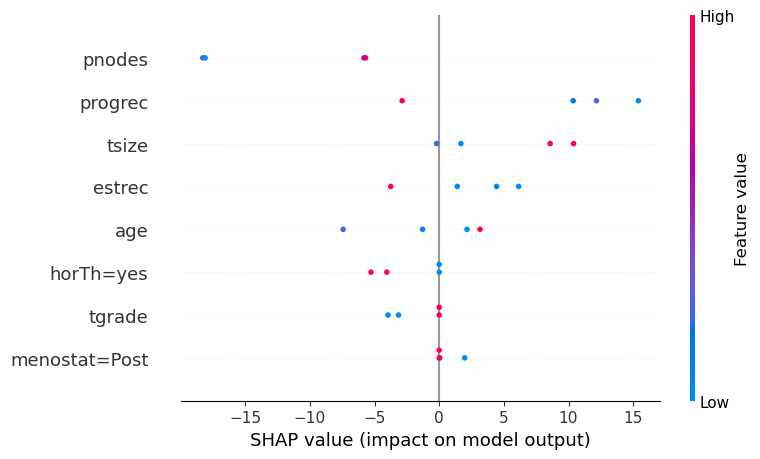

In [67]:
shap_vals = ex.shap_values(X_test[sel_mask])
shap.summary_plot(shap_vals, X_test[sel_mask])

# AIDS

## Data